In [1]:
#-- Import Required Libraries

from nba_api.stats.endpoints import playergamelog
from nba_api.stats.library.parameters import SeasonAll
import pandas as pd 
pd.options.mode.chained_assignment = None
import numpy as np
from scipy.interpolate import make_interp_spline

import seaborn as sns
import matplotlib.pyplot as plt

#---------- Define Vars for Plotting -----------------#
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)


In [2]:
#-- Define player IDs

player_names = ['Lebron James', 'Kareem Abdul-Jabbar', 'Karl Malone', 'Kobe Bryant', 'Michael Jordan', 'Dirk Nowitzki']

player_ids = [2544, 76003, 252, 977, 893, 1717]

#-- Retrive data from API 
game_logs =[]
for i in player_ids:
    game_logs.append(playergamelog.PlayerGameLog(player_id=i, season = SeasonAll.all).get_data_frames()[0].sort_index(ascending = False).reset_index(drop = True))

player_data = dict(zip(player_names, game_logs))

#-- Make the date an actual date-time object
for i in player_names:
    player_data[i]['GAME_DATE'] = pd.to_datetime(player_data[i]['GAME_DATE'])

#-- Get an ID for each season based off start year
for i in player_names:
    player_data[i]['SEASON_YEAR'] = None
    for x in range(len(player_data[i]['SEASON_ID'])):
        player_data[i]['SEASON_YEAR'][x] = pd.to_numeric(player_data[i]['SEASON_ID'][x][1:])

/var/folders/bh/f_n1lys118dd__48sbs22ffm0000gn/T/ipykernel_74141/2991274412.py:64: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


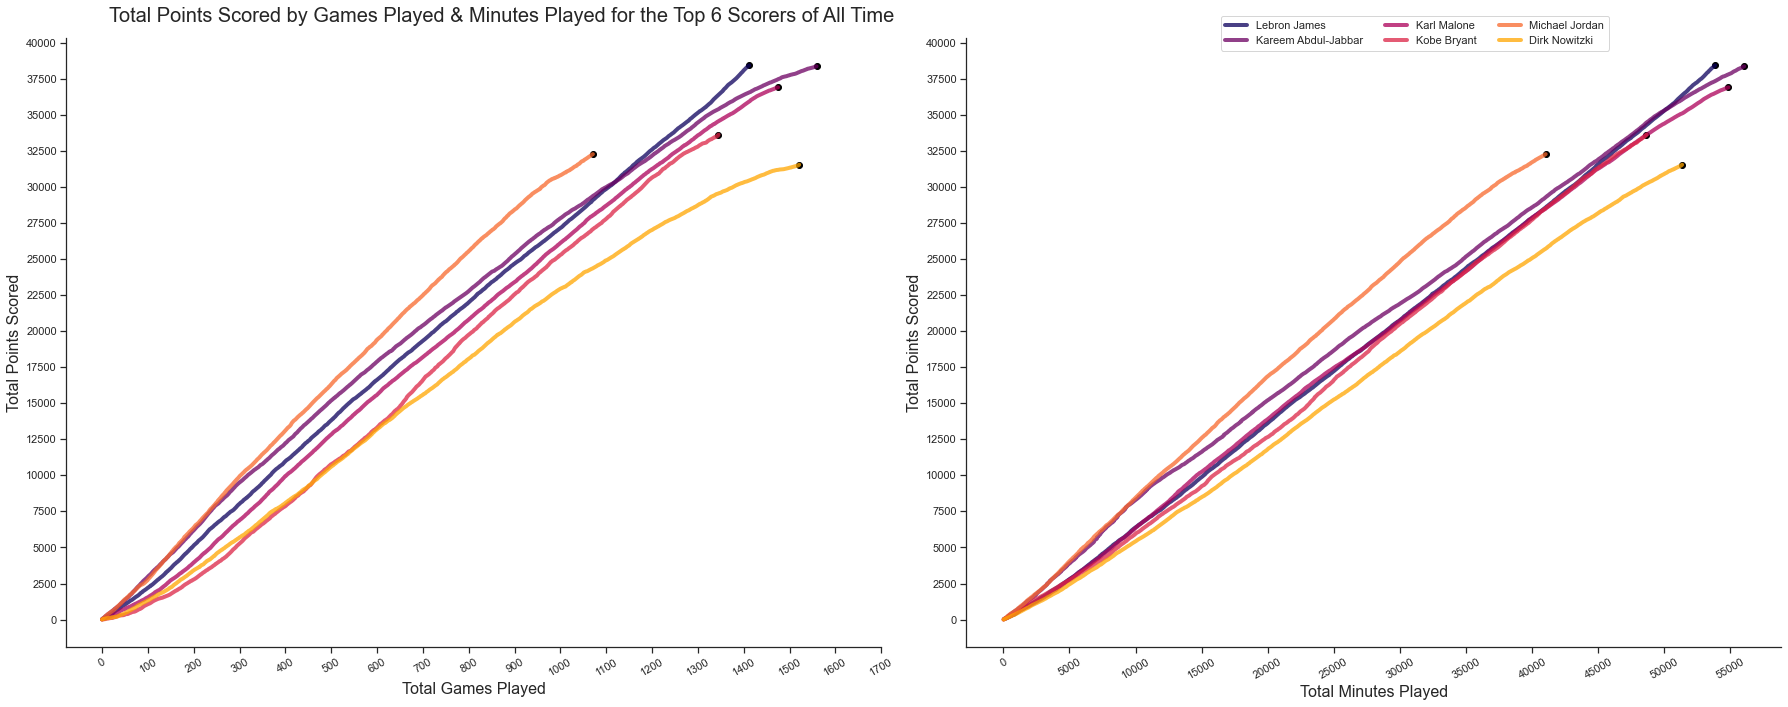

In [4]:
#####################################
###    All Time Scorers Plot      ###
#####################################

fig, ax = plt.subplots(1, 2, sharey = False, figsize = (25, 10))
colors = ['#0c005c', '#6c0062', '#ad0059', '#dc2446', '#f8682c', '#ffa600']
sns.set_palette(colors)
fontparams = {'font' : 'Arial', 'fontsize' : 16}

#-- Player career total points based on games played 
for i in player_names:
    ax[0].plot(player_data[i].PTS.cumsum()
               , linewidth = 4
               , alpha = .75)
    
for i in player_names:
    ax[0].scatter(x = player_data[i].index[-1]
                  , y = player_data[i].PTS.cumsum().iloc[-1]
                  , marker = 'o'
                  , color = 'black'
                  #, s = 10
                  )    

ax[0].set_xticks(range(0, 1800, 100))
ax[0].set_xticklabels(labels = range(0,1800,100), rotation = 30)
ax[0].set_xlabel('Total Games Played', fontdict = fontparams)

ax[0].set_yticks(range(0, 42500, 2500))
ax[0].set_yticklabels(labels = range(0, 42500, 2500))
ax[0].set_ylabel('Total Points Scored', fontdict = fontparams)

#ax[0].set_title('Total Points Scored by Games Played & Minutes Played for the Top 6 Scorers of All Time'
#                , loc = 'left'
#                , fontdict = {'font' : 'Arial', 'fontsize' : 20})

# ax[0].legend(player_names)

#-- Player career total points based on minutes played
for i in player_names:
    ax[1].plot(player_data[i].MIN.cumsum()
                , player_data[i].PTS.cumsum()
                , linewidth = 4
                , alpha = .75)
    
for i in player_names:
    ax[1].scatter(player_data[i].MIN.cumsum().iloc[-1]
                , player_data[i].PTS.cumsum().iloc[-1]
                , color = 'black'
                #, s = .75
                )    

ax[1].set_xticks(range(0, 60000, 5000))
ax[1].set_xticklabels(range(0, 60000, 5000), rotation = 30)                
ax[1].set_xlabel('Total Minutes Played', fontdict = fontparams)

ax[1].set_yticks(range(0, 42500, 2500))
ax[1].set_yticklabels(labels = range(0, 42500, 2500))
ax[1].set_ylabel('Total Points Scored', fontdict = fontparams)

fig.suptitle('Total Points Scored by Games Played & Minutes Played for the Top 6 Scorers of All Time', ha = 'right', fontsize = 20)
fig.legend(player_names, bbox_to_anchor=(.90, .975), ncol = 3)
fig.tight_layout()
fig.savefig('total_points_for_top_six_all_time.png', dpi = 300)
fig.show()


In [5]:
#---------- Load in Inflation Data -------------#
ldata = pd.read_csv('nba_league_per_game_averages.csv')

#--------------- Data cleanup -------------#

#-- Get the year from the season column for joining and plotting uses
ldata['YEAR'] = pd.to_numeric(ldata['Season'].apply(lambda x: x[:4]))

#-- Sort data so 1946 is at the top and 2022 at the bottom 
ldata = ldata.sort_values(by = 'Rk', ascending = False).reset_index(drop = True)

#-- Calculate scoring inflation YoY
ldata['POINT_GROWTH'] = ldata.PTS / ldata.PTS.shift(periods = 1) - 1 #-- raw YoY average scoring growth
ldata['TPI'] = ldata.PTS / 100 #-- establish CPI comparison
ldata['SCORING_INFLATION'] = ldata.TPI / ldata.TPI.shift(periods = 1) - 1 #-- Calculate the ∆ in the TPI YoY


#-- Set the index to the YEAR column
ldata.set_index('YEAR', inplace = True)

/var/folders/bh/f_n1lys118dd__48sbs22ffm0000gn/T/ipykernel_74141/2192683002.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


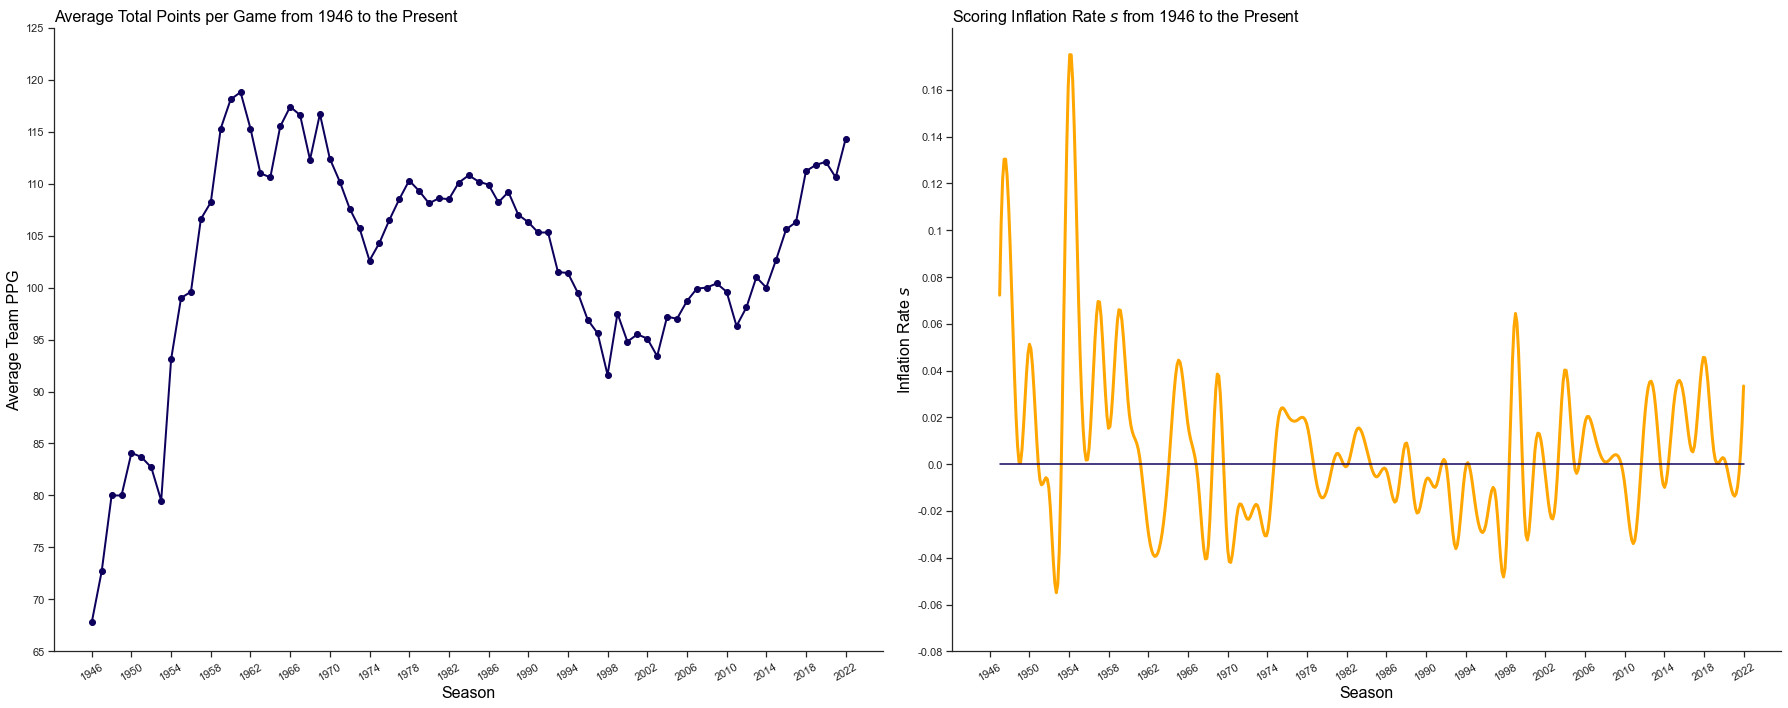

In [6]:
#------------- Inflation Plot ------------------#
fig, ax = plt.subplots(1, 2, sharex=True, figsize = (25, 10))
sns.set_palette('magma')
fontparams = {'font' : 'Arial', 'fontsize' : 16, 'color' : 'black'}

#-- Team Average PPG --#
ax[0].plot(ldata.PTS
            , linewidth = 2
            , marker = 'o')

x_0_ticks = range(1946, 2026, 4)
ax[0].set_xticks(x_0_ticks)
ax[0].set_xticklabels(x_0_ticks, rotation = 30)
ax[0].set_xlabel('Season', fontdict = fontparams)

y_0_ticks = range(65, 130, 5)
ax[0].set_yticks(y_0_ticks)
ax[0].set_yticklabels(y_0_ticks)
ax[0].set_ylabel('Average Team PPG', fontdict = fontparams)

ax[0].set_title('Average Total Points per Game from 1946 to the Present'
                , loc = 'left'
                , fontdict = fontparams)

#-- Inflation --#
x_vec_1 = pd.to_numeric(ldata.reset_index().YEAR)[1:]
y_vec_1 = ldata.SCORING_INFLATION.dropna()

X_Y_Spline_1 = make_interp_spline(x_vec_1, y_vec_1)
 
# Returns evenly spaced numbers
# over a specified interval.
X_1 = np.linspace(x_vec_1.min(), x_vec_1.max(), 500)
Y_1 = X_Y_Spline_1(X_1)

# Plotting the Graph
ax[1].plot(X_1, Y_1
            , linewidth = 3
            , color = '#ffa600')

ax[1].plot(X_1, np.linspace(0,0,500))

ax[1].set_xticklabels(x_0_ticks, rotation = 30)
ax[1].set_xlabel('Season', fontdict = fontparams)

ax[1].set_yticks(np.round( np.arange(-.08, .18, step = .02), 2))
ax[1].set_yticklabels(np.round( np.arange(-.08, .18, step = .02), 2))
ax[1].set_ylabel('Inflation Rate $s$', fontdict = fontparams)
ax[1].set_title('Scoring Inflation Rate $s$ from 1946 to the Present'
                , loc = 'left'
                , fontdict = fontparams)

#-- Final output display
fig.savefig('scoring_inflation_and_points_plot.png', dpi = 300)
fig.tight_layout()
fig.show()


/var/folders/bh/f_n1lys118dd__48sbs22ffm0000gn/T/ipykernel_74141/1387031565.py:51: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


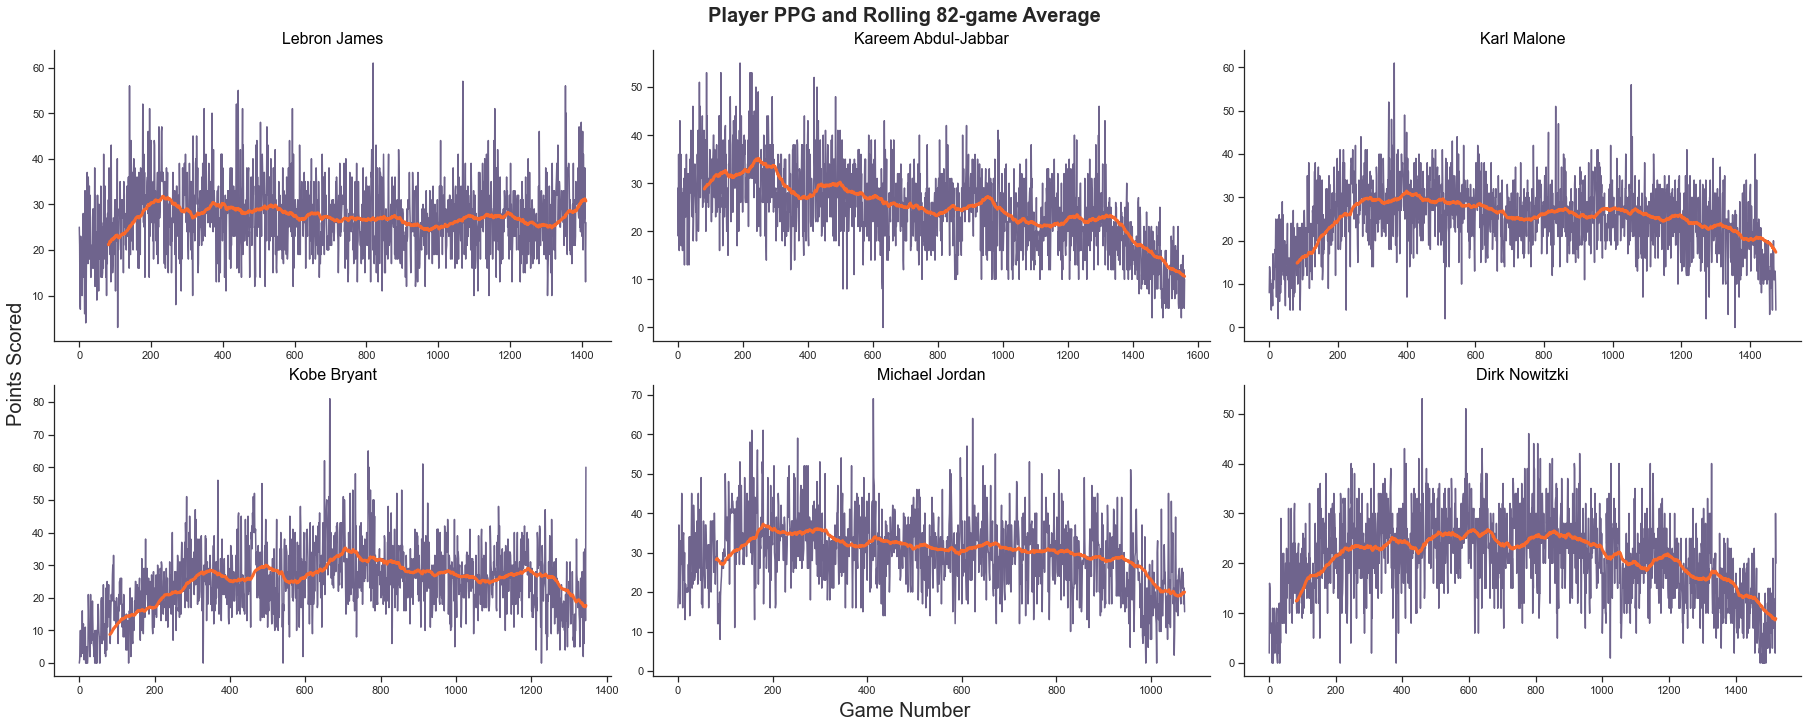

In [7]:
#----------- Velocity Plots ------------#
fig, axs = plt.subplots(2, 3, constrained_layout = True, figsize = (25, 10))
fontparams = {'family' : 'Arial', 'size' : 16, 'color' : 'black'}
colors = ['#0c005c', '#6c0062', '#ad0059', '#dc2446', '#f8682c', '#ffa600']
sns.set_palette(colors)

window_size = 82

#-- LBJ 
axs[0, 0].plot(player_data[player_names[0]].PTS, alpha = .65)
axs[0, 0].plot(player_data[player_names[0]].PTS.rolling(window = window_size).mean()
                , linewidth = 3, color = colors[4])
axs[0, 0].set_title(player_names[0], loc = 'center', fontdict = fontparams)
#axs[0, 0].legend(['LeBron James PPG', '82 Game Rolling Average'])

#-- KAJ 
axs[0, 1].plot(player_data[player_names[1]].PTS, alpha = .65)
axs[0, 1].plot(player_data[player_names[1]].PTS.rolling(window = window_size).mean()
                , linewidth = 3, color = colors[4])
axs[0, 1].set_title(player_names[1], loc = 'center', fontdict = fontparams)

#-- KM
axs[0, 2].plot(player_data[player_names[2]].PTS, alpha = .65)
axs[0, 2].plot(player_data[player_names[2]].PTS.rolling(window = window_size).mean()
                , linewidth = 3, color = colors[4])
axs[0, 2].set_title(player_names[2], loc = 'center', fontdict = fontparams)

#-- KB
axs[1, 0].plot(player_data[player_names[3]].PTS, alpha = .65)
axs[1, 0].plot(player_data[player_names[3]].PTS.rolling(window = window_size).mean()
                , linewidth = 3, color = colors[4])
axs[1, 0].set_title(player_names[3], loc = 'center', fontdict = fontparams)

#-- MJ
axs[1, 1].plot(player_data[player_names[4]].PTS, alpha = .65)
axs[1, 1].plot(player_data[player_names[4]].PTS.rolling(window = window_size).mean()
                , linewidth = 3, color = colors[4])
axs[1, 1].set_title(player_names[4], loc = 'center', fontdict = fontparams)

#-- DN
axs[1, 2].plot(player_data[player_names[5]].PTS, alpha = .65)
axs[1, 2].plot(player_data[player_names[5]].PTS.rolling(window = window_size).mean()
                , linewidth = 3, color = colors[4])
axs[1, 2].set_title(player_names[5], loc = 'center', fontdict = fontparams)

#-- Final output details 
fig.suptitle('Player PPG and Rolling 82-game Average', size = 20, weight =  'bold')
fig.supxlabel('Game Number', size = 20)
fig.supylabel('Points Scored', size = 20)
fig.savefig('six_player_ppg_velocity.png', dpi = 300)
fig.show()

### Method A

In [10]:
ldata.columns

Index(['Rk', 'Season', 'Lg', 'Age', 'Ht', 'Wt', 'G', 'MP', 'FG', 'FGA', '3P',
       '3PA', 'FT', 'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'PTS', 'FG%', '3P%', 'FT%', 'Pace', 'eFG%', 'TOV%', 'ORB%',
       'FT/FGA', 'ORtg', 'POINT_GROWTH', 'TPI', 'SCORING_INFLATION'],
      dtype='object')

In [14]:
player_data['Lebron James'].join(ldata[['PTS', 'POINT_GROWTH', 'TPI', 'SCORING_INFLATION']], on = 'SEASON_YEAR', rsuffix = '_LGA', how = 'left')

,SEASON_ID,Player_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,...,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,SEASON_YEAR,PTS_LGA,POINT_GROWTH,TPI,SCORING_INFLATION
0,22003,2544,0020300014,2003-10-29,CLE @ SAC,L,42,12,20,0.600,...,2,3,25,-9,0,2003,93.4,-0.017876,0.934,-0.017876
1,22003,2544,0020300018,2003-10-30,CLE @ PHX,L,41,8,17,0.471,...,7,1,21,-3,0,2003,93.4,-0.017876,0.934,-0.017876
2,22003,2544,0020300038,2003-11-01,CLE @ POR,L,39,3,12,0.250,...,2,3,8,-21,0,2003,93.4,-0.017876,0.934,-0.017876
3,22003,2544,0020300057,2003-11-05,CLE vs. DEN,L,41,3,11,0.273,...,2,1,7,-3,0,2003,93.4,-0.017876,0.934,-0.017876
4,22003,2544,0020300068,2003-11-07,CLE @ IND,L,44,8,18,0.444,...,7,2,23,-7,0,2003,93.4,-0.017876,0.934,-0.017876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1408,22022,2544,0022200798,2023-02-04,LAL @ NOP,L,40,10,22,0.455,...,2,2,27,-5,1,2022,114.3,0.033454,1.143,0.033454
1409,22022,2544,0022200821,2023-02-07,LAL vs. OKC,L,34,13,20,0.650,...,4,3,38,8,1,2022,114.3,0.033454,1.143,0.033454
1410,22022,2544,0022200882,2023-02-15,LAL vs. NOP,W,29,7,14,0.500,...,4,1,21,14,1,2022,114.3,0.033454,1.143,0.033454
1411,22022,2544,0022200893,2023-02-23,LAL vs. GSW,W,26,5,20,0.250,...,2,2,13,22,1,2022,114.3,0.033454,1.143,0.033454


In [15]:
inflation_df = pd.DataFrame()

for i in player_names:

    player_data[i] = player_data[i].join(ldata[['PTS', 'POINT_GROWTH', 'TPI', 'SCORING_INFLATION']], on = 'SEASON_YEAR', rsuffix = '_LGA', how = 'left')

    x = player_data[i].groupby('SEASON_YEAR')[['PTS', 'SCORING_INFLATION']].mean()
    y = player_data[i].groupby('SEASON_YEAR').Game_ID.count()
    x = x.join(y)

    x['PLAYER'] = i
    x['AVG_PTS_LAG'] = x.PTS.shift(periods = 1)
    x['NOMINAL_PTS_RATE'] = x['PTS'] / x['AVG_PTS_LAG'] - 1
    x['REAL_PTS_RATE'] = x['NOMINAL_PTS_RATE'] - x['SCORING_INFLATION']
    x['REAL_PTS_AVG'] = x['AVG_PTS_LAG'] * (1 + x['REAL_PTS_RATE'])
    x['NOMINAL_PTS_TOTAL'] = x['PTS'] * x['Game_ID']
    x['REAL_PTS_TOTAL'] = x['REAL_PTS_AVG'] * x['Game_ID']
    x['REAL_PTS_TOTAL'].iloc[0] = x['NOMINAL_PTS_TOTAL'].iloc[0]

    inflation_df = pd.concat([inflation_df, x])

methodA_pivot = inflation_df.pivot_table(index = 'PLAYER'
                         , values = ['NOMINAL_PTS_TOTAL', 'REAL_PTS_TOTAL']
                         , aggfunc = 'sum').round(0)

methodA_pivot.columns = ['NOMINAL', 'REAL']

methodA_pivot['DIFFERENCE'] = methodA_pivot['NOMINAL'] - methodA_pivot['REAL']

methodA_pivot

,NOMINAL,REAL,DIFFERENCE
PLAYER,,,
Dirk Nowitzki,31560.0,31370.0,190.0
Kareem Abdul-Jabbar,38387.0,38549.0,-162.0
Karl Malone,36928.0,37230.0,-302.0
Kobe Bryant,33643.0,33504.0,139.0
Lebron James,38450.0,38070.0,380.0
Michael Jordan,32292.0,32551.0,-259.0


In [16]:
#-- Create a Pivot Table where we can see cumulative inflation adjusted points for each player

inflation_pivot = inflation_df.pivot_table(index = 'SEASON_YEAR'
                         , columns = 'PLAYER'
                         , values = 'REAL_PTS_TOTAL'
                         , aggfunc = 'mean')

#-- Set the years in between Jordan's career activity to 0 instead of NaN
inflation_pivot.loc[1993, 'Michael Jordan'] = 0
inflation_pivot.loc[1998, 'Michael Jordan'] = 0
inflation_pivot.loc[1999, 'Michael Jordan'] = 0
inflation_pivot.loc[2000, 'Michael Jordan'] = 0

#-- Cumulative sum all the values in the DataFrame 
inflation_pivot = inflation_pivot.cumsum()

#-- Join on information about scoring inflation
inflation_pivot = inflation_pivot.join(ldata[['TPI', 'SCORING_INFLATION']], how = 'left')

/var/folders/bh/f_n1lys118dd__48sbs22ffm0000gn/T/ipykernel_74141/2857906553.py:72: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


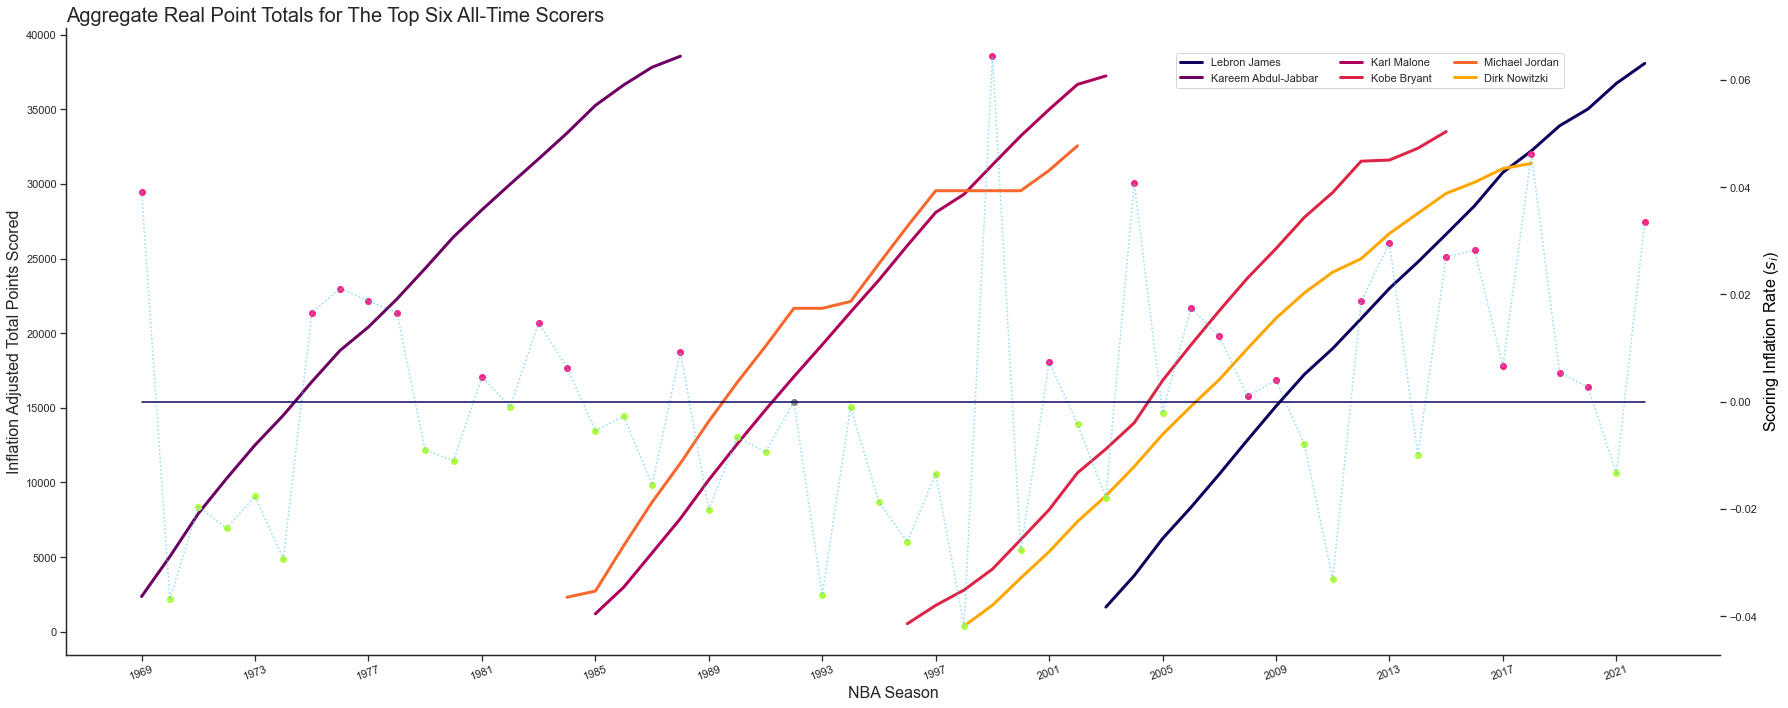

In [17]:
############################################################
###           Inflation Adjusted Scorers Plot            ###
############################################################


fig,ax = plt.subplots( figsize = (25, 10) )
colors = ['#0c005c', '#6c0062', '#ad0059', '#dc2446', '#f8682c', '#ffa600']
sns.set_palette(colors)


ax.plot(inflation_pivot[player_names]
        , linewidth = 3
        )

ax.set_xticks(
    range(
    np.min(inflation_pivot.index)
    , np.max(inflation_pivot.index)
    , 4
    )
)
    
ax.set_xticklabels(
        range(
        np.min(inflation_pivot.index)
        , np.max(inflation_pivot.index)
        , 4
        )
    , rotation = 20
)

ax.set_xlabel('NBA Season'
              , fontdict = {'size' : 16})

ax.set_ylabel('Inflation Adjusted Total Points Scored'
              , fontdict = {'size' : 16})

ax.set_title('Aggregate Real Point Totals for The Top Six All-Time Scorers'
           , fontdict = {'size' : 20}
           , loc = 'left')

# twin object for two different y-axis on the sample plot
ax2 = ax.twinx()
# make a plot with different y-axis using second axis object

ax2.plot(inflation_pivot['SCORING_INFLATION']
         , color = "#4CC9F0"
         #, marker="o"
         , alpha = .65
         , linestyle = ':')

ax2.scatter(inflation_pivot.loc[inflation_pivot['SCORING_INFLATION'] > 0].index
            ,inflation_pivot.loc[inflation_pivot['SCORING_INFLATION'] > 0].SCORING_INFLATION
            , c = '#F72585')

ax2.scatter(inflation_pivot.loc[inflation_pivot['SCORING_INFLATION'] < 0].index
            ,inflation_pivot.loc[inflation_pivot['SCORING_INFLATION'] < 0].SCORING_INFLATION
            , c = '#AFFC41')

ax2.scatter(inflation_pivot.loc[inflation_pivot['SCORING_INFLATION'] == 0].index
            ,inflation_pivot.loc[inflation_pivot['SCORING_INFLATION'] == 0].SCORING_INFLATION
            , c = 'grey')

ax2.plot(inflation_pivot.index, np.linspace(0,0,len(inflation_pivot.index)))


ax2.set_ylabel("Scoring Inflation Rate ($s_{i}$)", color = "black", fontsize = 16)

fig.legend(inflation_pivot[player_names].columns, bbox_to_anchor = (.875, .925), ncol = 3)
fig.savefig('real_points_with_inflation_rate.png', dpi = 300)
fig.tight_layout()
fig.show()

### Method B

In [18]:
#-- Code in Discounted Points --#

for i in player_names:
   
    player_data[i]['PTS_DISCOUNTED'] = player_data[i]['PTS'] / (1 + player_data[i]['SCORING_INFLATION'])

    base_year = np.min(player_data[i].SEASON_YEAR)
    
    player_data[i].loc[player_data[i]['SEASON_YEAR'] == base_year, 'PTS_DISCOUNTED'] = player_data[i].loc[player_data[i]['SEASON_YEAR'] == base_year, 'PTS'] 

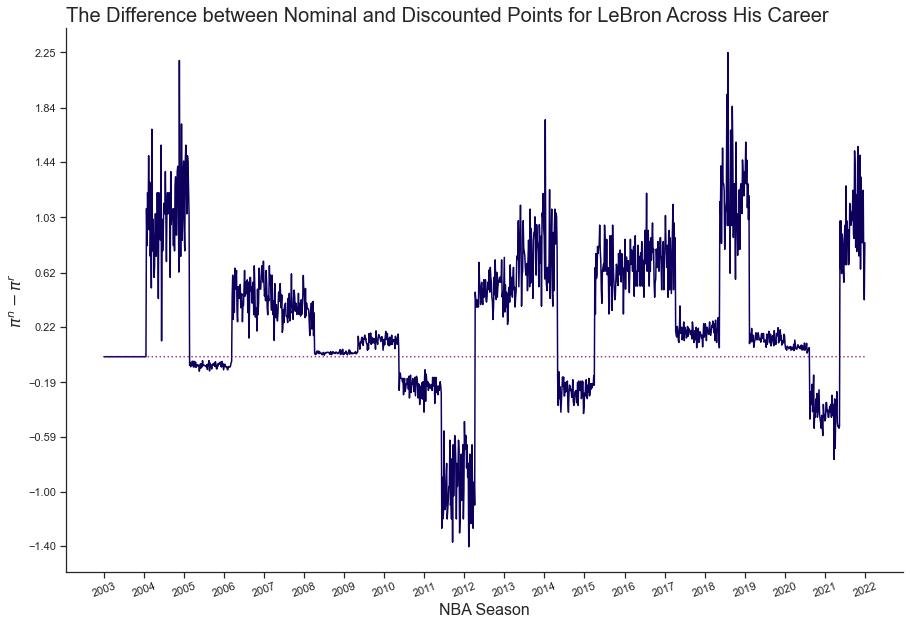

In [19]:
############################################################
###           Inflation Discount Impact Plot             ###
############################################################

plt.figure(figsize = (15, 10))

y_vector = player_data['Lebron James']['PTS'] - player_data['Lebron James']['PTS_DISCOUNTED']

plt.plot(y_vector)

plt.plot(
        np.linspace(0
                , 0
                , num = len(player_data['Lebron James']))
        , alpha = .75
        , linestyle = ":"
)

xlabels = player_data['Lebron James']['SEASON_YEAR'].unique()
xlabels = pd.Series(xlabels).apply(lambda x: str(x))

plt.xticks(
    np.linspace(player_data["Lebron James"].index.min()
                , player_data['Lebron James'].index.max()
                , num = 20)
    , xlabels
    , rotation = 20
)

plt.yticks(
    np.round(
        np.linspace(
            y_vector.min()
            , y_vector.max()
            , num = 10
        )
        , 2
    )
)

plt.xlabel('NBA Season', fontdict = {'size' : 16, 'family' : 'Arial'})
plt.ylabel('$\pi^{n} - \pi^{r}$', fontdict = {'size' : 16})
plt.title('The Difference between Nominal and Discounted Points for LeBron Across His Career'
          , loc = 'left'
          , fontdict = {'size' : 20, 'family' : 'Arial'})

plt.savefig('lebron_discounted_pts_difference.png', dpi = 400)
plt.show()

/var/folders/bh/f_n1lys118dd__48sbs22ffm0000gn/T/ipykernel_74141/303200637.py:47: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


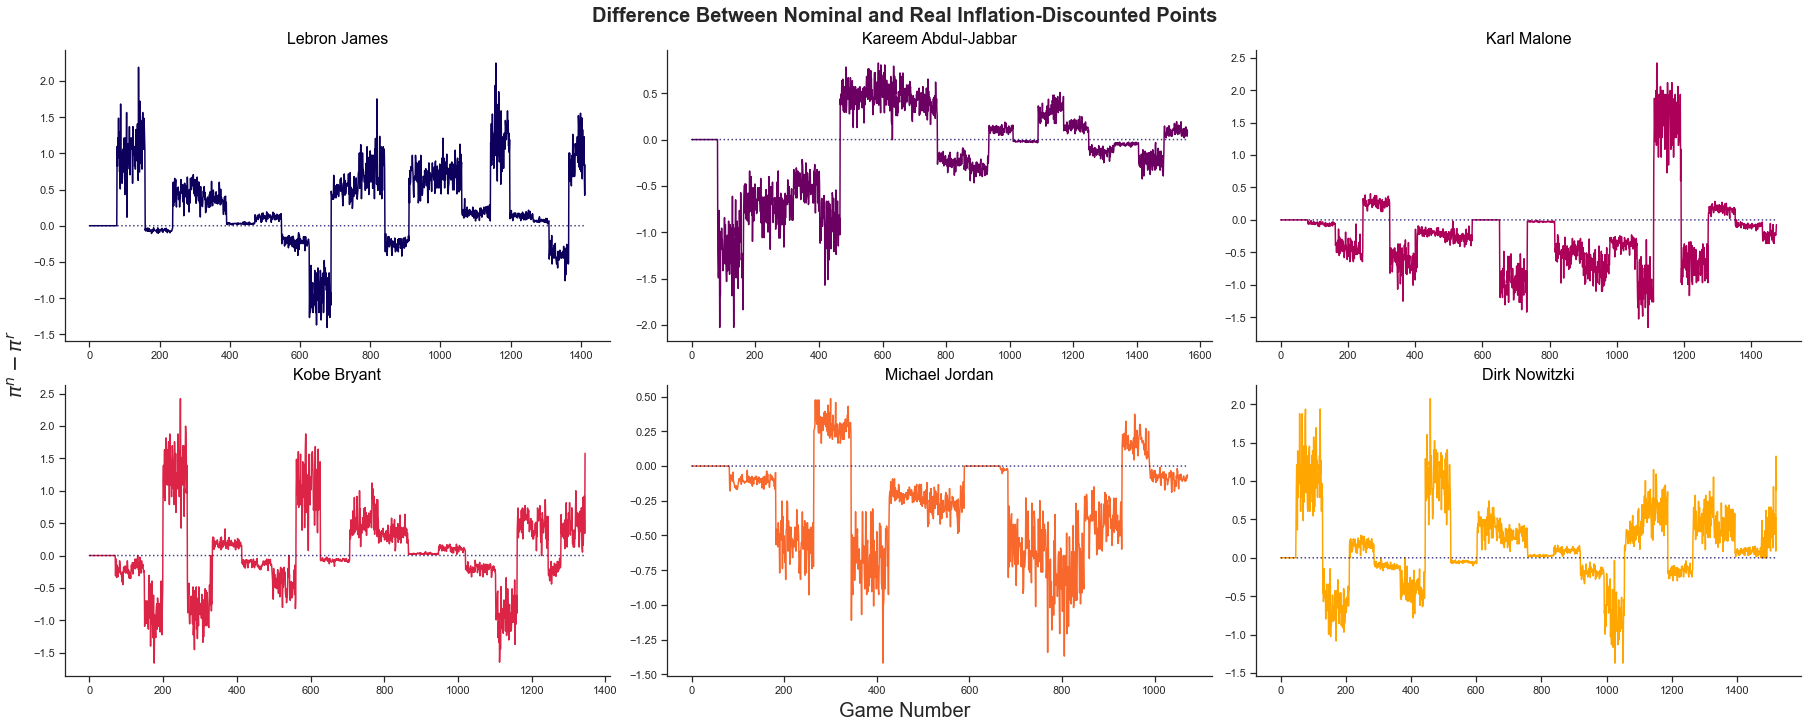

In [20]:
############################################################
###           Six Player Inflation Discount              ###
############################################################

fig, axs = plt.subplots(2, 3, constrained_layout = True, figsize = (25, 10))
fontparams = {'family' : 'Arial', 'size' : 16, 'color' : 'black'}

for i in range(6):

    if i < 3:

        axs[0, i].plot(
            (player_data[player_names[i]]['PTS'] - player_data[player_names[i]]['PTS_DISCOUNTED'])
             , color = colors[i]
        )

        axs[0, i].plot(
            np.linspace(0, 0, num = len(player_data[player_names[i]]))
            , linestyle = ":"
            , alpha = .75
        )

        axs[0, i].set_title(player_names[i]
                            , fontdict = fontparams)
        
    else: 

        axs[1, i - 3].plot(
            (player_data[player_names[i]]['PTS'] - player_data[player_names[i]]['PTS_DISCOUNTED'])
             , color = colors[i]
        )

        axs[1, i - 3].plot(
            np.linspace(0, 0, num = len(player_data[player_names[i]]))
            , linestyle = ":"
            , alpha = .75
        )

        axs[1, i - 3].set_title(player_names[i]
                            , fontdict = fontparams)
        
#-- Final output details 
fig.suptitle('Difference Between Nominal and Real Inflation-Discounted Points', size = 20, weight =  'bold')
fig.supxlabel('Game Number', size = 20)
fig.supylabel('$\pi^{n} - \pi^{r}$', size = 20)
fig.savefig('six_player_ppg_inflation_discount.png', dpi = 300)
fig.show()

In [23]:
#-- Calculate Averages for Inflation & Deflation Adjustments

discounted_data = pd.DataFrame()

for i in player_names:

    player_data[i]['PLAYER_NAME'] = i
    player_data[i]['DISCOUNTED_DIFF'] = player_data[i]['PTS'] - player_data[i]['PTS_DISCOUNTED']
    player_data[i]['INFLATIONARY_DIFF'] = np.where(player_data[i]['DISCOUNTED_DIFF'] > 0, player_data[i]['DISCOUNTED_DIFF'], np.nan)
    player_data[i]['DEFLATIONARY_DIFF'] = np.where(player_data[i]['DISCOUNTED_DIFF'] < 0, player_data[i]['DISCOUNTED_DIFF'], np.nan)

    discounted_data = pd.concat([discounted_data, player_data[i]])

#-- Output Check
discounted_data.pivot_table(
    index = 'PLAYER_NAME'
    , values = ['INFLATIONARY_DIFF', 'DEFLATIONARY_DIFF']
    , aggfunc = ['mean', 'count']
)

mean                               count  \
                    DEFLATIONARY_DIFF INFLATIONARY_DIFF DEFLATIONARY_DIFF   
PLAYER_NAME                                                                 
Dirk Nowitzki               -0.314692          0.417398               531   
Kareem Abdul-Jabbar         -0.445935          0.314685               863   
Karl Malone                 -0.430954          0.666035              1070   
Kobe Bryant                 -0.402176          0.485370               596   
Lebron James                -0.348279          0.505312               345   
Michael Jordan              -0.394555          0.242484               771   

                                       
                    INFLATIONARY_DIFF  
PLAYER_NAME                            
Dirk Nowitzki                     936  
Kareem Abdul-Jabbar               614  
Karl Malone                       242  
Kobe Bryant                       675  
Lebron James                      989  
Michael Jordan                    141

/var/folders/bh/f_n1lys118dd__48sbs22ffm0000gn/T/ipykernel_74141/1145877196.py:66: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


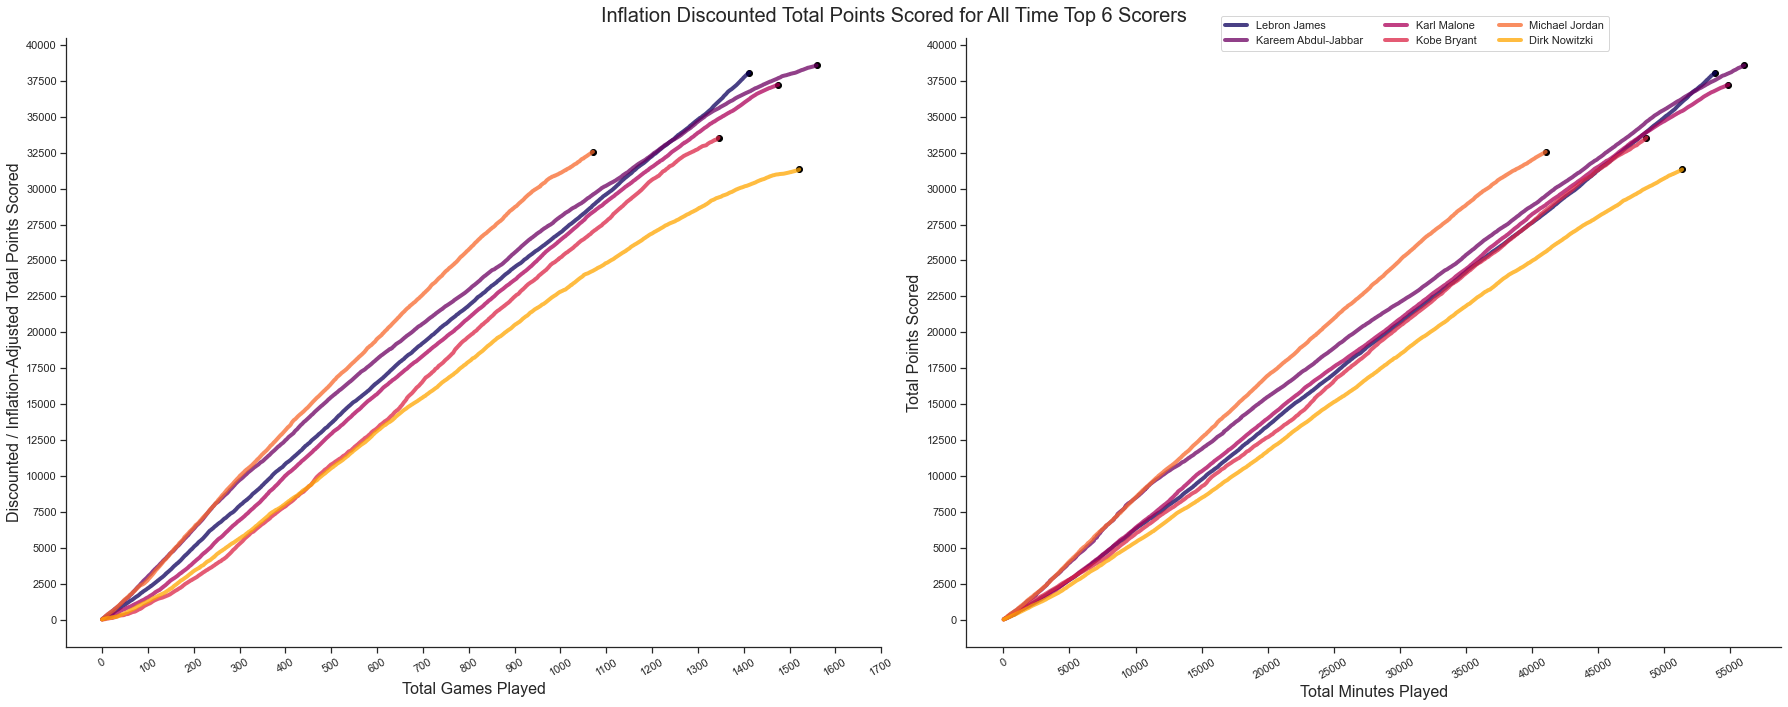

In [24]:
############################################################
###           Discounted Total Points Plot               ###
############################################################

#-- Initiate plot parameters
fig, ax = plt.subplots(1, 2, sharey = False, figsize = (25, 10))
colors = ['#0c005c', '#6c0062', '#ad0059', '#dc2446', '#f8682c', '#ffa600']
sns.set_palette(colors)
fontparams = {'font' : 'Arial', 'fontsize' : 16}

#-- Player career total discounted points based on GAMES played --#
for i in player_names:
    ax[0].plot(player_data[i].PTS_DISCOUNTED.cumsum() #-- cumsum makes this the total points scored
               , linewidth = 4
               , alpha = .75)
    
#-- Last game end dot to show where final values land
for i in player_names:
    ax[0].scatter(player_data[i].index[-1]
                , player_data[i].PTS_DISCOUNTED.cumsum().iloc[-1]
                , color = 'black'
                #, s = .75
                ) 

#-- X-axis parameters for total games played
ax[0].set_xticks(range(0, 1800, 100))
ax[0].set_xticklabels(labels = range(0,1800,100), rotation = 30)
ax[0].set_xlabel('Total Games Played', fontdict = fontparams)

#-- Y-axis parameters for aggregated points
ax[0].set_yticks(range(0, 42500, 2500))
ax[0].set_yticklabels(labels = range(0, 42500, 2500))
ax[0].set_ylabel('Discounted / Inflation-Adjusted Total Points Scored', fontdict = fontparams)


#-- Player career total discounted points based on MINUTES played --#
for i in player_names:
    ax[1].plot(player_data[i].MIN.cumsum()
                , player_data[i].PTS_DISCOUNTED.cumsum()
                , linewidth = 4
                , alpha = .75)

#-- Last game dot to show where final values land 
for i in player_names:
    ax[1].scatter(player_data[i].MIN.cumsum().iloc[-1]
                , player_data[i].PTS_DISCOUNTED.cumsum().iloc[-1]
                , color = 'black'
                #, s = .75
                ) 


#-- X-axis parameters for total minutes played
ax[1].set_xticks(range(0, 60000, 5000))
ax[1].set_xticklabels(range(0, 60000, 5000), rotation = 30)                
ax[1].set_xlabel('Total Minutes Played', fontdict = fontparams)

#-- Y-axis parameters for aggregated points
ax[1].set_yticks(range(0, 42500, 2500))
ax[1].set_yticklabels(labels = range(0, 42500, 2500))
ax[1].set_ylabel('Total Points Scored', fontdict = fontparams)

fig.suptitle('Inflation Discounted Total Points Scored for All Time Top 6 Scorers', ha = 'center', fontsize = 20)
fig.legend(player_names, bbox_to_anchor=(.90, .975), ncol = 3)
fig.tight_layout()
fig.savefig('Inflation_Discounted_Scorers_Plot.png', dpi = 500)
fig.show()

### Appendix

In [57]:
#-- Calculate how many 2-pointers a player made and attempted

for i in player_names:
    player_data[i]['FG2M'] = player_data[i]['FGM'].fillna(0) - player_data[i]['FG3M'].fillna(0)
    player_data[i]['FG2A'] = player_data[i]['FGA'].fillna(0) - player_data[i]['FG3A'].fillna(0)

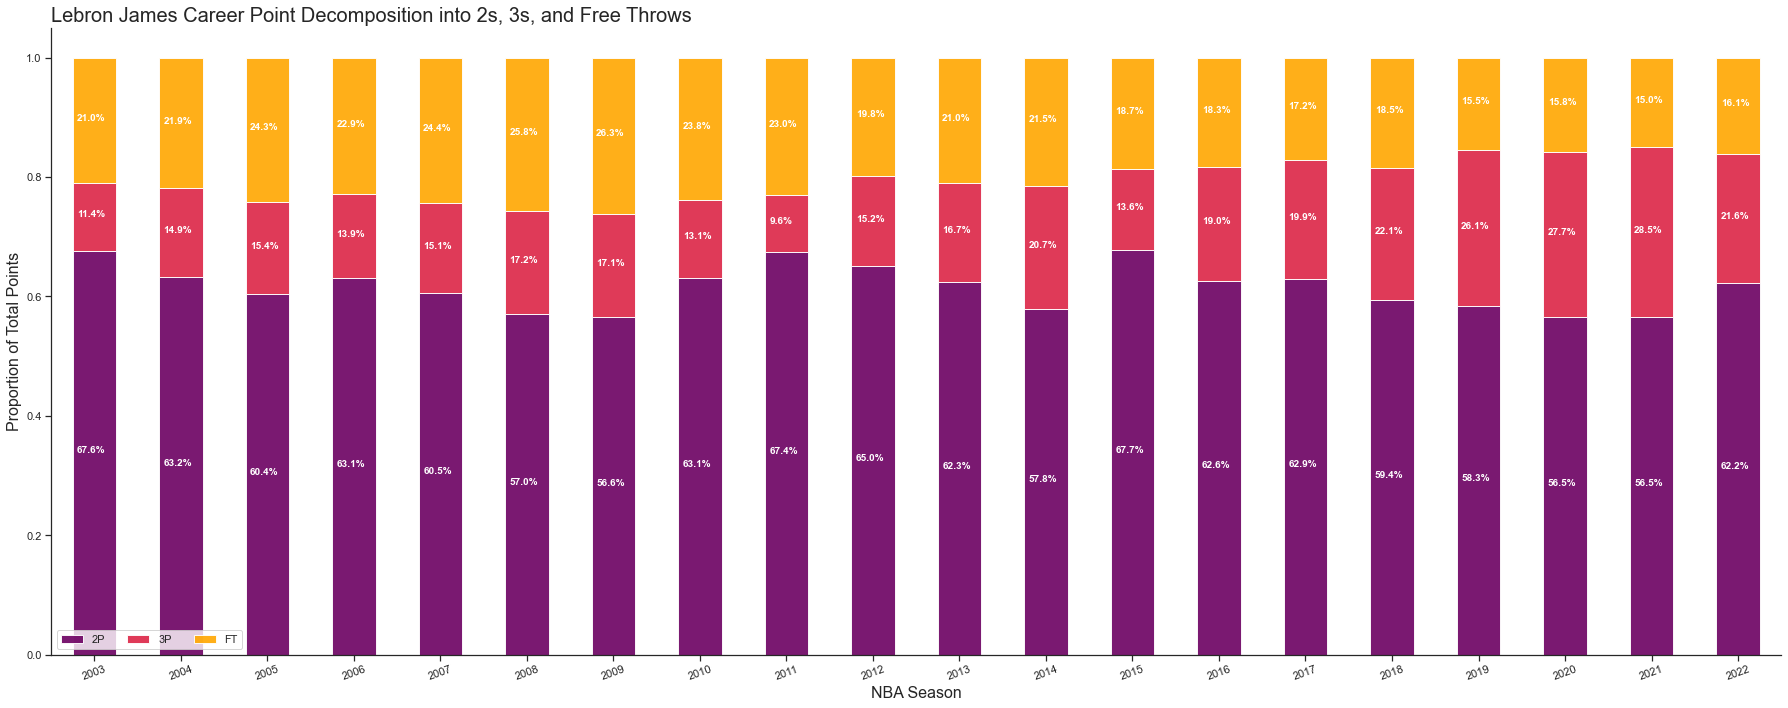

In [66]:
##################################################
#--- LeBron Point Decomposition Visualization ---#
##################################################

pname = 'Lebron James'

decomp_data = player_data[pname].groupby('SEASON_YEAR')[['FG2M', 'FG3M', 'FTM']].sum()

decomp_data['VALUE_TOTAL'] = decomp_data['FG2M'].fillna(0) * 2 + decomp_data['FG3M'].fillna(0) * 3 + decomp_data['FTM'].fillna(0)
decomp_data['FG2_SHARE'] = (decomp_data['FG2M'].fillna(0) * 2) / decomp_data['VALUE_TOTAL']
decomp_data['FG3_SHARE'] = (decomp_data['FG3M'].fillna(0) * 3) / decomp_data['VALUE_TOTAL']
decomp_data['FT_SHARE'] = decomp_data['FTM'].fillna(0) / decomp_data['VALUE_TOTAL']

decomp_data[['FG2_SHARE', 'FG3_SHARE', 'FT_SHARE']].plot(
    kind = 'bar'
    , stacked = True
    , figsize = (25, 10)
    , alpha = .9
    , color = [colors[1], colors[3], colors[5]]
    # , colormap = 'tab10'
)

plt.legend(labels = ['2P', '3P', 'FT'], loc="lower left", ncol = 3)
plt.xticks(rotation = 20)
plt.xlabel('NBA Season', fontdict = fontparams)
plt.ylabel("Proportion of Total Points", fontdict = fontparams)

for n, x in enumerate([*decomp_data.index.values]):
    for (proportion, y_loc) in zip(decomp_data[['FG2_SHARE', 'FG3_SHARE', 'FT_SHARE']].loc[x],
                                   decomp_data[['FG2_SHARE', 'FG3_SHARE', 'FT_SHARE']].loc[x].cumsum()):
                
        plt.text(x=n - 0.20,
                 y=(y_loc - proportion) + (proportion / 2),
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="white",
                 fontsize=10,
                 fontweight="bold")

        
plt.title('{} Career Point Decomposition into 2s, 3s, and Free Throws'.format(pname)
          , loc = 'left'
          , fontdict = {'size' : 20, 'family' : 'Arial'})

plt.tight_layout()
plt.savefig('{}_point_decomp.png'.format(pname), dpi = 300)
plt.show()

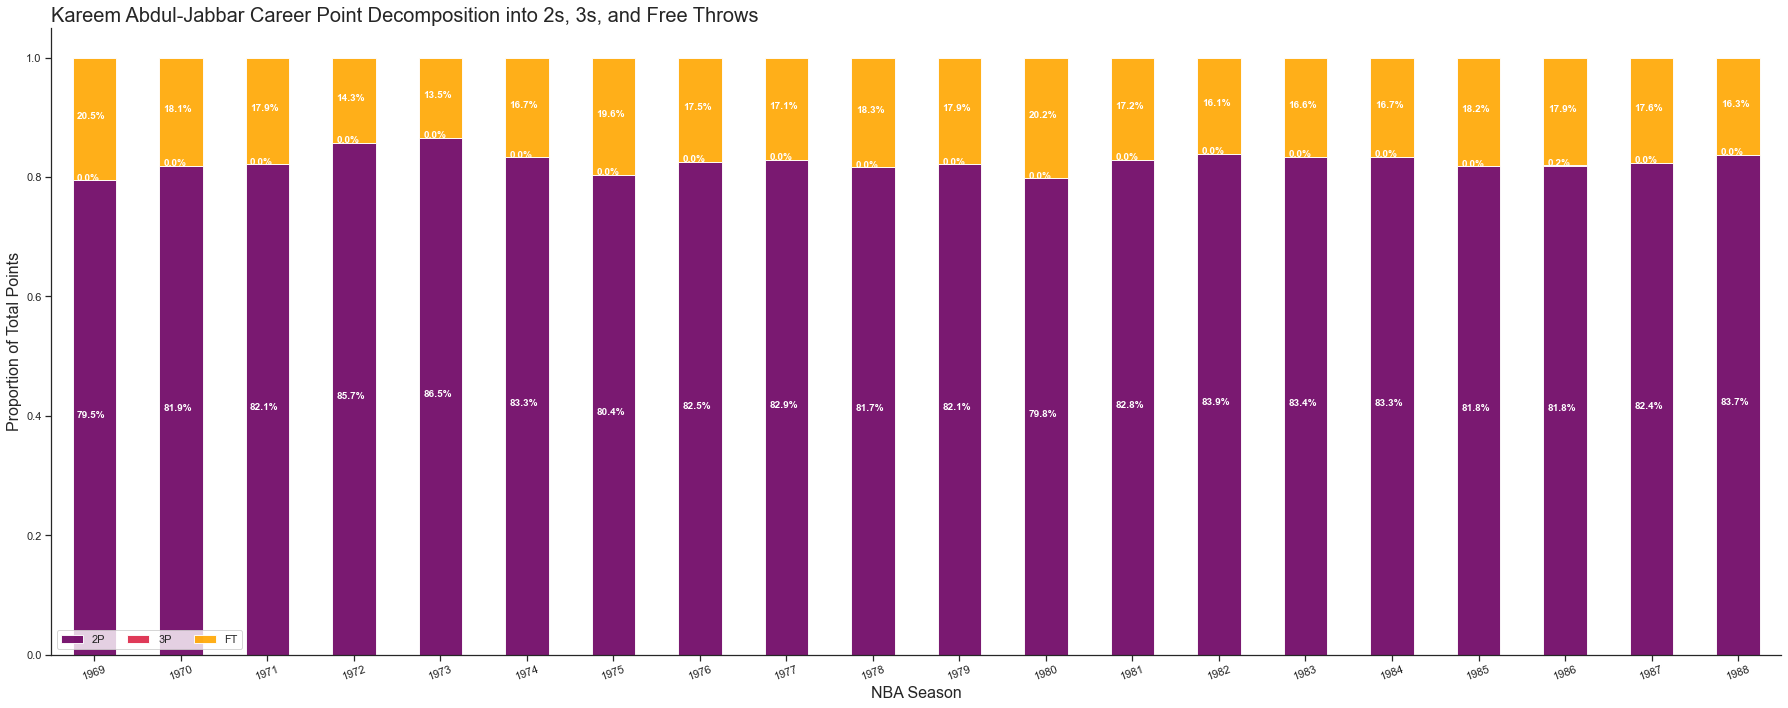

In [67]:
##################################################
#--- Kareem Point Decomposition Visualization ---#
##################################################

pname = 'Kareem Abdul-Jabbar'

decomp_data = player_data[pname].groupby('SEASON_YEAR')[['FG2M', 'FG3M', 'FTM']].sum()

decomp_data['VALUE_TOTAL'] = decomp_data['FG2M'].fillna(0) * 2 + decomp_data['FG3M'].fillna(0) * 3 + decomp_data['FTM'].fillna(0)
decomp_data['FG2_SHARE'] = (decomp_data['FG2M'].fillna(0) * 2) / decomp_data['VALUE_TOTAL']
decomp_data['FG3_SHARE'] = (decomp_data['FG3M'].fillna(0) * 3) / decomp_data['VALUE_TOTAL']
decomp_data['FT_SHARE'] = decomp_data['FTM'].fillna(0) / decomp_data['VALUE_TOTAL']

decomp_data[['FG2_SHARE', 'FG3_SHARE', 'FT_SHARE']].plot(
    kind = 'bar'
    , stacked = True
    , figsize = (25, 10)
    , alpha = .9
    , color = [colors[1], colors[3], colors[5]]
    # , colormap = 'tab10'
)

plt.legend(labels = ['2P', '3P', 'FT'], loc="lower left", ncol = 3)
plt.xticks(rotation = 20)
plt.xlabel('NBA Season', fontdict = fontparams)
plt.ylabel("Proportion of Total Points", fontdict = fontparams)

for n, x in enumerate([*decomp_data.index.values]):
    for (proportion, y_loc) in zip(decomp_data[['FG2_SHARE', 'FG3_SHARE', 'FT_SHARE']].loc[x],
                                   decomp_data[['FG2_SHARE', 'FG3_SHARE', 'FT_SHARE']].loc[x].cumsum()):
                
        plt.text(x=n - 0.20,
                 y=(y_loc - proportion) + (proportion / 2),
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="white",
                 fontsize=10,
                 fontweight="bold")

        
plt.title('{} Career Point Decomposition into 2s, 3s, and Free Throws'.format(pname)
          , loc = 'left'
          , fontdict = {'size' : 20, 'family' : 'Arial'})

plt.tight_layout()
plt.savefig('{}_point_decomp.png'.format(pname), dpi = 300)
plt.show()

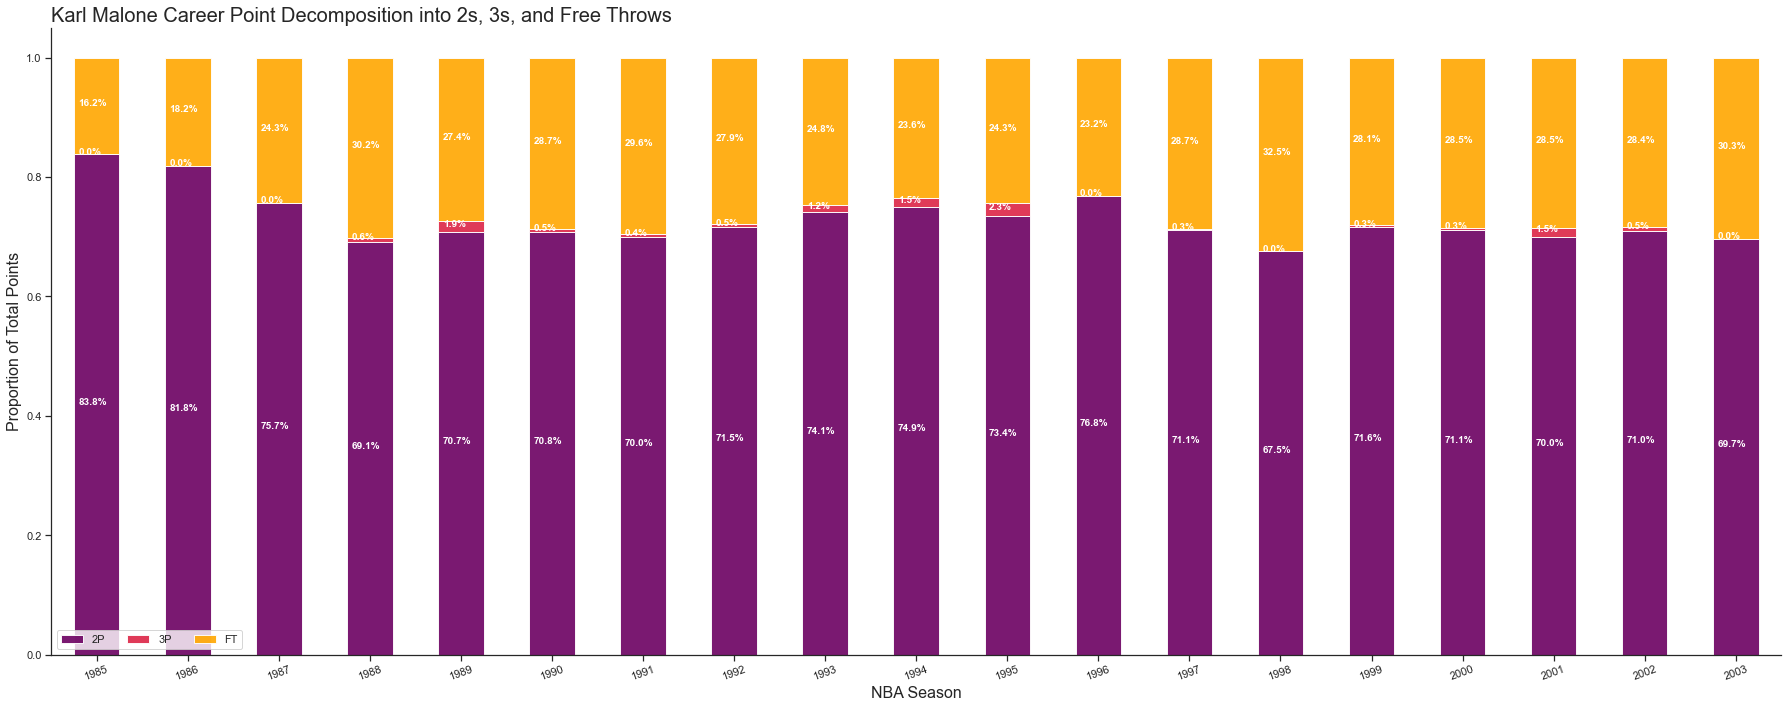

In [68]:
##################################################
#--- LeBron Point Decomposition Visualization ---#
##################################################

pname = 'Karl Malone'

decomp_data = player_data[pname].groupby('SEASON_YEAR')[['FG2M', 'FG3M', 'FTM']].sum()

decomp_data['VALUE_TOTAL'] = decomp_data['FG2M'].fillna(0) * 2 + decomp_data['FG3M'].fillna(0) * 3 + decomp_data['FTM'].fillna(0)
decomp_data['FG2_SHARE'] = (decomp_data['FG2M'].fillna(0) * 2) / decomp_data['VALUE_TOTAL']
decomp_data['FG3_SHARE'] = (decomp_data['FG3M'].fillna(0) * 3) / decomp_data['VALUE_TOTAL']
decomp_data['FT_SHARE'] = decomp_data['FTM'].fillna(0) / decomp_data['VALUE_TOTAL']

decomp_data[['FG2_SHARE', 'FG3_SHARE', 'FT_SHARE']].plot(
    kind = 'bar'
    , stacked = True
    , figsize = (25, 10)
    , alpha = .9
    , color = [colors[1], colors[3], colors[5]]
    # , colormap = 'tab10'
)

plt.legend(labels = ['2P', '3P', 'FT'], loc="lower left", ncol = 3)
plt.xticks(rotation = 20)
plt.xlabel('NBA Season', fontdict = fontparams)
plt.ylabel("Proportion of Total Points", fontdict = fontparams)

for n, x in enumerate([*decomp_data.index.values]):
    for (proportion, y_loc) in zip(decomp_data[['FG2_SHARE', 'FG3_SHARE', 'FT_SHARE']].loc[x],
                                   decomp_data[['FG2_SHARE', 'FG3_SHARE', 'FT_SHARE']].loc[x].cumsum()):
                
        plt.text(x=n - 0.20,
                 y=(y_loc - proportion) + (proportion / 2),
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="white",
                 fontsize=10,
                 fontweight="bold")

        
plt.title('{} Career Point Decomposition into 2s, 3s, and Free Throws'.format(pname)
          , loc = 'left'
          , fontdict = {'size' : 20, 'family' : 'Arial'})

plt.tight_layout()
plt.savefig('{}_point_decomp.png'.format(pname), dpi = 300)
plt.show()

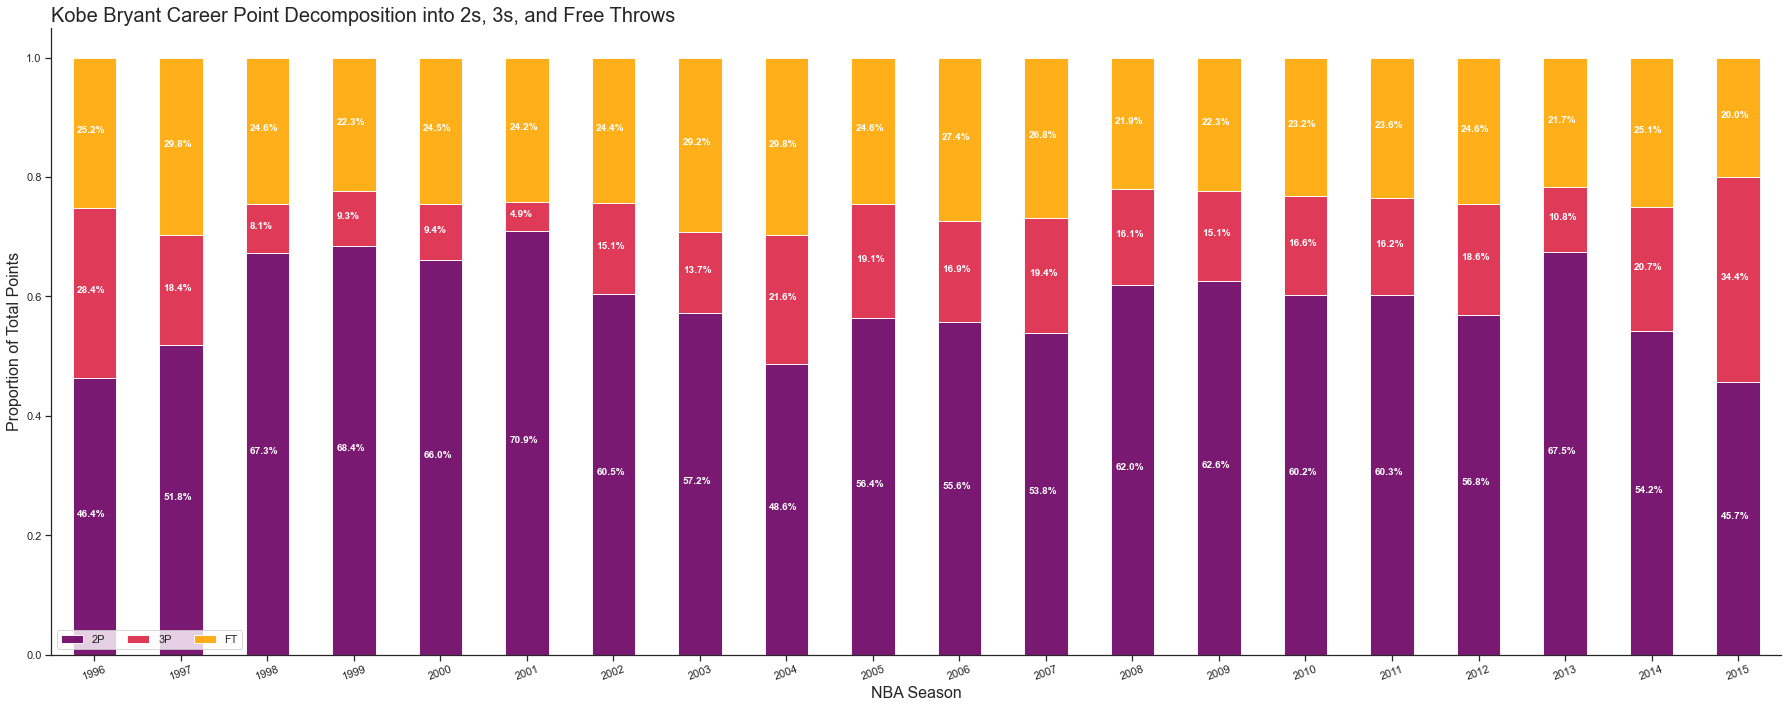

In [69]:
##################################################
#--- LeBron Point Decomposition Visualization ---#
##################################################

pname = 'Kobe Bryant'

decomp_data = player_data[pname].groupby('SEASON_YEAR')[['FG2M', 'FG3M', 'FTM']].sum()

decomp_data['VALUE_TOTAL'] = decomp_data['FG2M'].fillna(0) * 2 + decomp_data['FG3M'].fillna(0) * 3 + decomp_data['FTM'].fillna(0)
decomp_data['FG2_SHARE'] = (decomp_data['FG2M'].fillna(0) * 2) / decomp_data['VALUE_TOTAL']
decomp_data['FG3_SHARE'] = (decomp_data['FG3M'].fillna(0) * 3) / decomp_data['VALUE_TOTAL']
decomp_data['FT_SHARE'] = decomp_data['FTM'].fillna(0) / decomp_data['VALUE_TOTAL']

decomp_data[['FG2_SHARE', 'FG3_SHARE', 'FT_SHARE']].plot(
    kind = 'bar'
    , stacked = True
    , figsize = (25, 10)
    , alpha = .9
    , color = [colors[1], colors[3], colors[5]]
    # , colormap = 'tab10'
)

plt.legend(labels = ['2P', '3P', 'FT'], loc="lower left", ncol = 3)
plt.xticks(rotation = 20)
plt.xlabel('NBA Season', fontdict = fontparams)
plt.ylabel("Proportion of Total Points", fontdict = fontparams)

for n, x in enumerate([*decomp_data.index.values]):
    for (proportion, y_loc) in zip(decomp_data[['FG2_SHARE', 'FG3_SHARE', 'FT_SHARE']].loc[x],
                                   decomp_data[['FG2_SHARE', 'FG3_SHARE', 'FT_SHARE']].loc[x].cumsum()):
                
        plt.text(x=n - 0.20,
                 y=(y_loc - proportion) + (proportion / 2),
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="white",
                 fontsize=10,
                 fontweight="bold")

        
plt.title('{} Career Point Decomposition into 2s, 3s, and Free Throws'.format(pname)
          , loc = 'left'
          , fontdict = {'size' : 20, 'family' : 'Arial'})

plt.tight_layout()
plt.savefig('{}_point_decomp.png'.format(pname), dpi = 300)
plt.show()

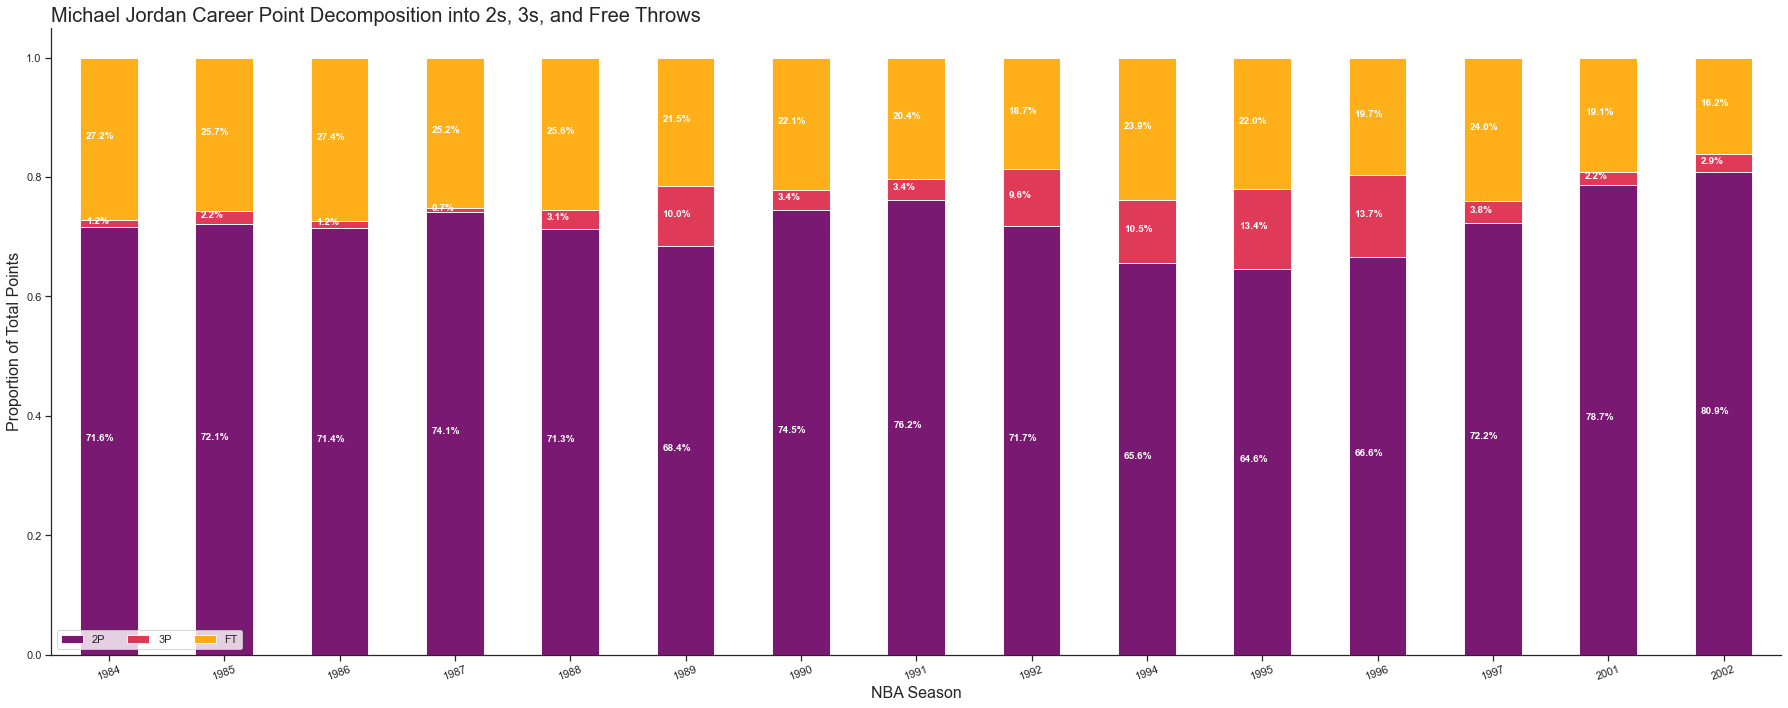

In [70]:
##################################################
#--- LeBron Point Decomposition Visualization ---#
##################################################

pname = 'Michael Jordan'

decomp_data = player_data[pname].groupby('SEASON_YEAR')[['FG2M', 'FG3M', 'FTM']].sum()

decomp_data['VALUE_TOTAL'] = decomp_data['FG2M'].fillna(0) * 2 + decomp_data['FG3M'].fillna(0) * 3 + decomp_data['FTM'].fillna(0)
decomp_data['FG2_SHARE'] = (decomp_data['FG2M'].fillna(0) * 2) / decomp_data['VALUE_TOTAL']
decomp_data['FG3_SHARE'] = (decomp_data['FG3M'].fillna(0) * 3) / decomp_data['VALUE_TOTAL']
decomp_data['FT_SHARE'] = decomp_data['FTM'].fillna(0) / decomp_data['VALUE_TOTAL']

decomp_data[['FG2_SHARE', 'FG3_SHARE', 'FT_SHARE']].plot(
    kind = 'bar'
    , stacked = True
    , figsize = (25, 10)
    , alpha = .9
    , color = [colors[1], colors[3], colors[5]]
    # , colormap = 'tab10'
)

plt.legend(labels = ['2P', '3P', 'FT'], loc="lower left", ncol = 3)
plt.xticks(rotation = 20)
plt.xlabel('NBA Season', fontdict = fontparams)
plt.ylabel("Proportion of Total Points", fontdict = fontparams)

for n, x in enumerate([*decomp_data.index.values]):
    for (proportion, y_loc) in zip(decomp_data[['FG2_SHARE', 'FG3_SHARE', 'FT_SHARE']].loc[x],
                                   decomp_data[['FG2_SHARE', 'FG3_SHARE', 'FT_SHARE']].loc[x].cumsum()):
                
        plt.text(x=n - 0.20,
                 y=(y_loc - proportion) + (proportion / 2),
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="white",
                 fontsize=10,
                 fontweight="bold")

        
plt.title('{} Career Point Decomposition into 2s, 3s, and Free Throws'.format(pname)
          , loc = 'left'
          , fontdict = {'size' : 20, 'family' : 'Arial'})

plt.tight_layout()
plt.savefig('{}_point_decomp.png'.format(pname), dpi = 300)
plt.show()

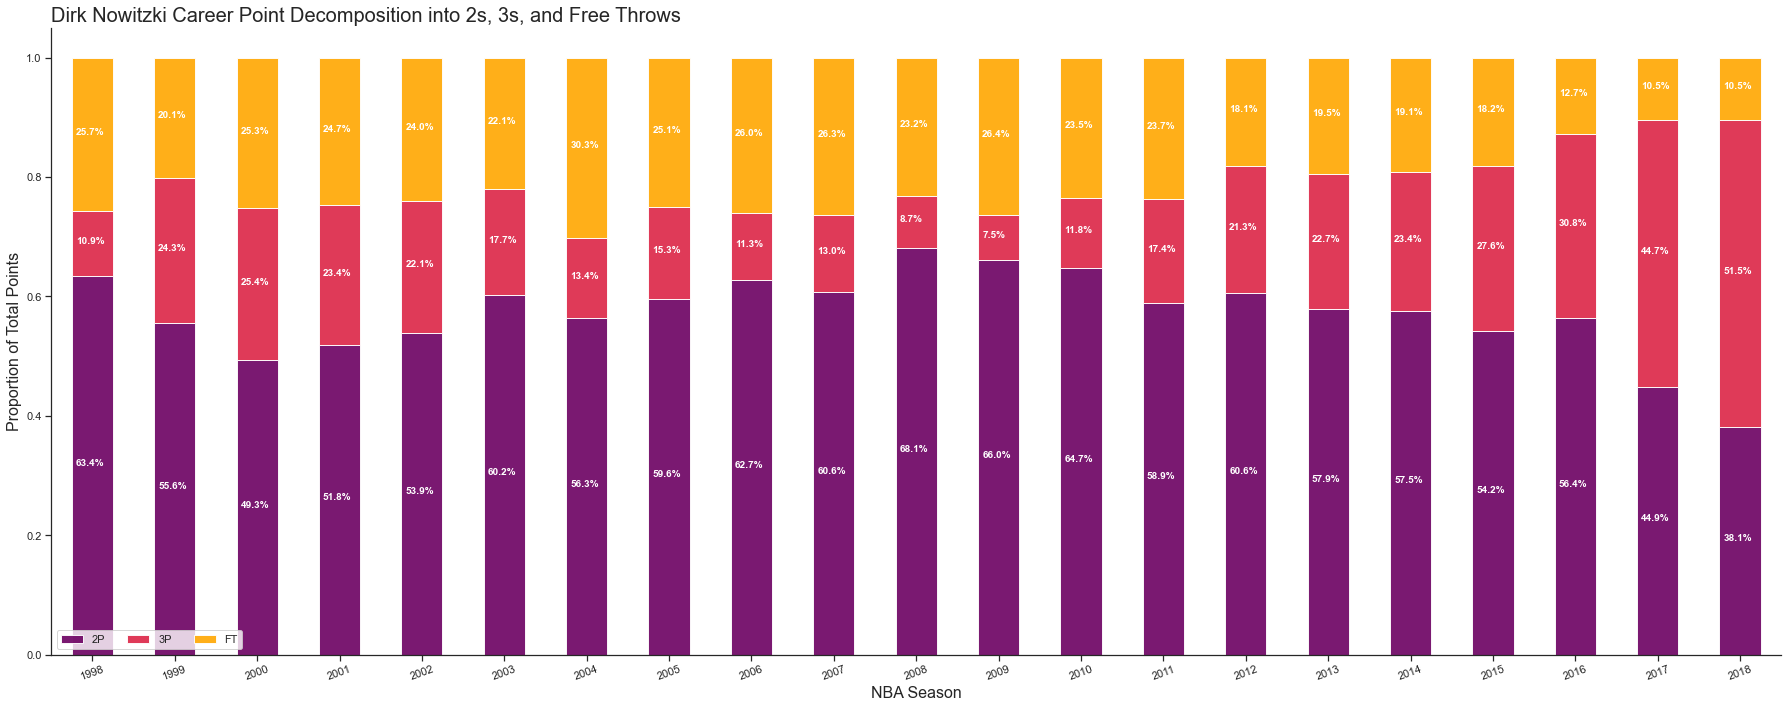

In [71]:
##################################################
#--- LeBron Point Decomposition Visualization ---#
##################################################

pname = 'Dirk Nowitzki'

decomp_data = player_data[pname].groupby('SEASON_YEAR')[['FG2M', 'FG3M', 'FTM']].sum()

decomp_data['VALUE_TOTAL'] = decomp_data['FG2M'].fillna(0) * 2 + decomp_data['FG3M'].fillna(0) * 3 + decomp_data['FTM'].fillna(0)
decomp_data['FG2_SHARE'] = (decomp_data['FG2M'].fillna(0) * 2) / decomp_data['VALUE_TOTAL']
decomp_data['FG3_SHARE'] = (decomp_data['FG3M'].fillna(0) * 3) / decomp_data['VALUE_TOTAL']
decomp_data['FT_SHARE'] = decomp_data['FTM'].fillna(0) / decomp_data['VALUE_TOTAL']

decomp_data[['FG2_SHARE', 'FG3_SHARE', 'FT_SHARE']].plot(
    kind = 'bar'
    , stacked = True
    , figsize = (25, 10)
    , alpha = .9
    , color = [colors[1], colors[3], colors[5]]
    # , colormap = 'tab10'
)

plt.legend(labels = ['2P', '3P', 'FT'], loc="lower left", ncol = 3)
plt.xticks(rotation = 20)
plt.xlabel('NBA Season', fontdict = fontparams)
plt.ylabel("Proportion of Total Points", fontdict = fontparams)

for n, x in enumerate([*decomp_data.index.values]):
    for (proportion, y_loc) in zip(decomp_data[['FG2_SHARE', 'FG3_SHARE', 'FT_SHARE']].loc[x],
                                   decomp_data[['FG2_SHARE', 'FG3_SHARE', 'FT_SHARE']].loc[x].cumsum()):
                
        plt.text(x=n - 0.20,
                 y=(y_loc - proportion) + (proportion / 2),
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="white",
                 fontsize=10,
                 fontweight="bold")

        
plt.title('{} Career Point Decomposition into 2s, 3s, and Free Throws'.format(pname)
          , loc = 'left'
          , fontdict = {'size' : 20, 'family' : 'Arial'})

plt.tight_layout()
plt.savefig('{}_point_decomp.png'.format(pname), dpi = 300)
plt.show()

<AxesSubplot:>

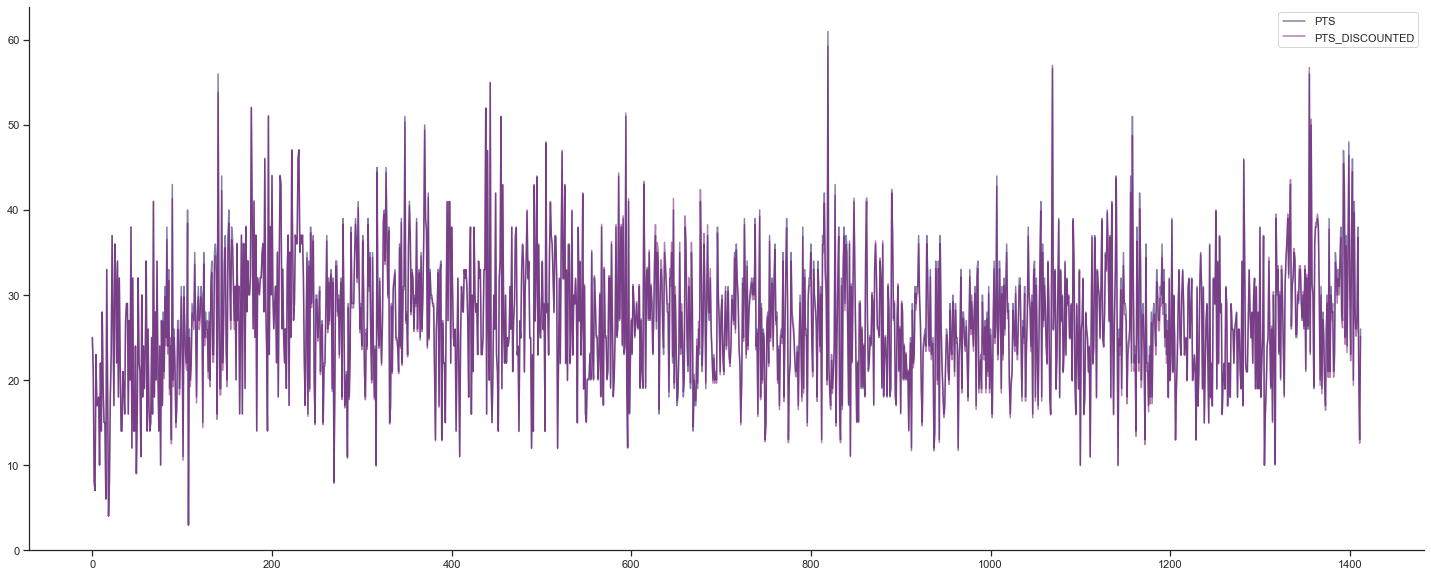

In [75]:
player_data['Lebron James'][['PTS', 'PTS_DISCOUNTED']].plot(figsize = (25, 10), alpha = .5)